In [2]:
import argparse
import os
import time
import base64
from matplotlib import pyplot as plt

import cv2
from nms import nms
import numpy as np

import pytesseract
import re



In [136]:
def deskew(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.bitwise_not(gray)

    # threshold the image, setting all foreground pixels to
    # 255 and all background pixels to 0
    thresh = cv2.threshold(gray, 0, 255,
                           cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

    # grab the (x, y) coordinates of all pixel values that
    # are greater than zero, then use these coordinates to
    # compute a rotated bounding box that contains all
    # coordinates
    coords = np.column_stack(np.where(thresh > 0))
    angle = cv2.minAreaRect(coords)[-1]

    # the `cv2.minAreaRect` function returns values in the
    # range [-90, 0); as the rectangle rotates clockwise the
    # returned angle trends to 0 -- in this special case we
    # need to add 90 degrees to the angle
    if angle < -45:
        angle = -(90 + angle)

    # otherwise, just take the inverse of the angle to make
    # it positive
    else:
        angle = -angle

    # rotate the image to deskew it
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    # draw the correction angle on the image so we can validate it
    return rotated

In [155]:
def thresholding(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img,None,fx=0.5,fy=0.5,interpolation=cv2.INTER_CUBIC)
    img = cv2.bilateralFilter(img,10,75,75)
    cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 31, 2)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    return img

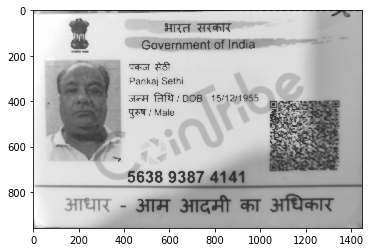

In [175]:
orig = img =cv2.imread(r'test.jpg')

img = deskew(img)
img = thresholding(img)

CONFIDENCE_THRESHOLD=15
config = ("--oem 3 --psm 11 -l eng -c preserve_interword_spaces=1" )
extracted_data = pytesseract.image_to_data(img, output_type=pytesseract.Output.DATAFRAME, config=config)

In [176]:
extracted_data = extracted_data.dropna()
extracted_data.text = extracted_data.text.map(lambda x: re.sub(r'[^a-zA-Z0-9\/]+', '', x))
extracted_data = extracted_data[(extracted_data.conf > CONFIDENCE_THRESHOLD)  & (extracted_data.text.str.len()>2)]
extracted_data



,level,page_num,block_num,par_num,line_num,word_num,left,top,width,height,conf,text
24,5,1,5,1,1,1,477,132,303,43,91,Government
26,5,1,5,1,1,3,859,129,120,43,91,India
35,5,1,7,1,1,1,425,297,124,38,86,Pankaj
36,5,1,7,1,1,2,568,296,91,31,92,Sethi
42,5,1,8,1,1,3,660,371,86,33,69,DOB
44,5,1,8,1,1,5,788,371,204,32,85,15/12/1955
50,5,1,9,1,1,3,536,434,85,31,91,Male
58,5,1,11,1,1,1,417,706,153,54,96,5638
59,5,1,11,1,1,2,596,707,157,55,96,9387
60,5,1,11,1,1,3,776,701,160,89,95,4141


In [177]:
dob = extracted_data[extracted_data.text.str.match(r'\d+/\d+/\d+')]
print(dob.text)

44    15/12/1955
Name: text, dtype: object


In [173]:
aadhar_uid = extracted_data[(extracted_data.text.str.match(r'\d{4}'))]
aadhar_uid

,level,page_num,block_num,par_num,line_num,word_num,left,top,width,height,conf,text
58,5,1,11,1,1,1,417,706,153,54,96,5638
59,5,1,11,1,1,2,596,707,157,55,96,9387
60,5,1,11,1,1,3,776,701,160,89,95,4141


In [174]:
# Add Sanity checks such as masking area ,etc.  
